# IMPORT LIBRARIES AND DATASET

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import random 

import os
import cv2
#import gdown
from zipfile import ZipFile
from tensorflow.keras import layers
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
import gc


In [2]:
#os.makedirs("celeba_gan")
#pip install gdown

In [3]:
#os.makedirs("celeba_gan")

#url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
#url = "https://cseweb.ucsd.edu/~weijian/static/datasets/celeba/img_align_celeba.zip"
#output = "celeba_gan/data.zip"
#gdown.download(url, output, quiet=True)

#with ZipFile("celeba_gan/data.zip", "r") as zipobj:
#    zipobj.extractall("celeba_gan")

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2bfab019570>)

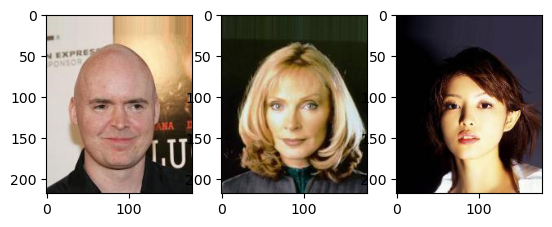

In [4]:
folder = 'celeba/img_align_celeba'
samples = os.listdir(folder)
#print(samples)

img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(131), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(132), plt.imshow(img)
img = cv2.cvtColor(cv2.imread(os.path.join(folder, np.random.choice(samples))), cv2.COLOR_BGR2RGB)
plt.subplot(133), plt.imshow(img)

In [5]:
#size = 64 
# new size 178×218
x, y = [],[]
t= []
i=0
for sample in tqdm(samples):
    i=i +1
    if i > 2011:
        break
    img = cv2.cvtColor(cv2.imread(os.path.join(folder, sample)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (176, 216))
    if i > 2001:
        t.append(img)
    if i < 2001:  
        x.append(img)
  

  1%|          | 2011/202599 [00:01<02:22, 1404.69it/s]


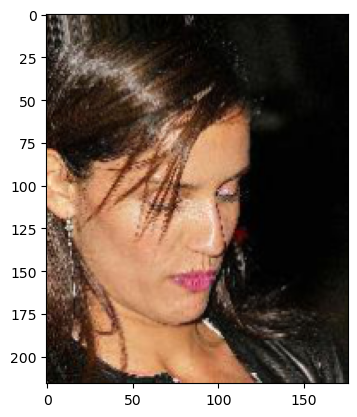

In [6]:
plt.imshow(x[3])

# Preprocessing data

In [7]:
X_train = np.array(x)/255

del x
gc.collect()

X_test = np.array(t)/255

del t
gc.collect()


0

In [8]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.044
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy

In [9]:
noise_factor = 0.3

noise_dataset = []

for img in X_train:
  noisy_image = img + noise_factor * np.random.randn(*img.shape)
  #noisy_image = noisy("s&p" ,img)
  noisy_image = np.clip(noisy_image, 0., 1.)
  noise_dataset.append(noisy_image)

In [10]:
noise_dataset = np.array(noise_dataset)
noise_dataset.shape

(2000, 216, 176, 3)

10

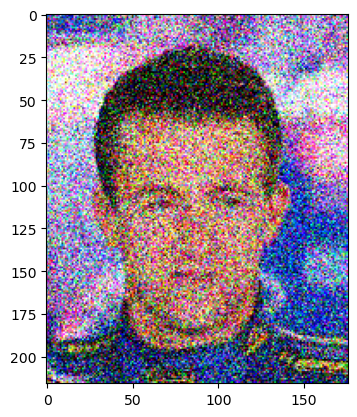

In [11]:
plt.imshow(noise_dataset[22])
gc.collect()

In [12]:
noise_test_set = []
for img in X_test:
  noisy_image = img + noise_factor * np.random.randn(*img.shape)
  #noisy_image = noisy("s&p" ,img)
  noisy_image = np.clip(noisy_image, 0., 1.)
  noise_test_set.append(noisy_image)
  
noise_test_set = np.array(noise_test_set)
noise_test_set.shape

(10, 216, 176, 3)

In [13]:
gc.collect()

3027

BUILD AND TRAIN AUTOENCODER DEEP LEARNING MODEL

An autoencoder is an unsupervised learning technique for neural networks that learns efficient data representations (encoding) by training the network to ignore signal “noise.”

In [14]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])

In [15]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'


autoencoder = tf.keras.models.Sequential()

#Encoder
autoencoder.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(216, 176, 3)))
autoencoder.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, activation='sigmoid', padding="same"))


In [16]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=["accuracy"])
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 88, 16)       448       
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 44, 8)         1160      
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 44, 8)         584       
                                                                 
 conv2d_transpose (Conv2DTra  (None, 108, 88, 16)      1168      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 216, 176, 3)      435       
 ranspose)                                                       
                                                                 
Total params: 3,795
Trainable params: 3,795
Non-trainabl

c:\Anaconda3\envs\vvv3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
63/63 [==============================] - 16s 261ms/step - loss: 0.5194 - accuracy: 0.7413 - val_loss: 0.4613 - val_accuracy: 0.7801
Epoch 2/50
63/63 [==============================] - 14s 216ms/step - loss: 0.5034 - accuracy: 0.7620 - val_loss: 0.4550 - val_accuracy: 0.8003
Epoch 3/50
63/63 [==============================] - 15s 240ms/step - loss: 0.4968 - accuracy: 0.7955 - val_loss: 0.4513 - val_accuracy: 0.7979
Epoch 4/50
63/63 [==============================] - 16s 255ms/step - loss: 0.4952 - accuracy: 0.8019 - val_loss: 0.4501 - val_accuracy: 0.8025
Epoch 5/50
63/63 [==============================] - 13s 204ms/step - loss: 0.4941 - accuracy: 0.8056 - val_loss: 0.4498 - val_accuracy: 0.8138
Epoch 6/50
63/63 [==============================] - 13s 202ms/step - loss: 0.4936 - accuracy: 0.8086 - val_loss: 0.4488 - val_accuracy: 0.8155
Epoch 7/50
63/63 [==============================] - 13s 207ms/step - loss: 0.4930 - accuracy: 0.8104 - val_loss: 0.4485 - val_accuracy: 0.8142

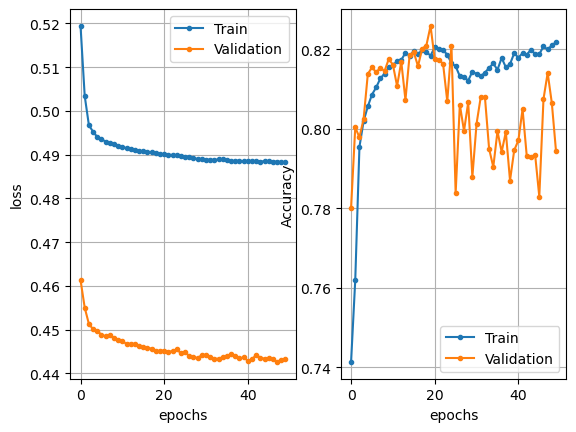

In [18]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

#gen = ImageDataGenerator(horizontal_flip=True, rescale=1/255, preprocessing_function=to_grayscale_then_rgb)

gen = ImageDataGenerator(horizontal_flip=True)

batches = gen.flow(noise_dataset.reshape(-1, 216, 176, 3), X_train.reshape(-1, 216, 176, 3), batch_size=32)
val_batches = gen.flow(noise_test_set.reshape(-1, 216, 176, 3), X_test.reshape(-1, 216, 176, 3), batch_size=32)

#model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

#history = autoencoder.fit_generator(batches, epochs=2,
#                    validation_data=val_batches,  callbacks=[early_stopping], use_multiprocessing=True)
log_dir="logs/model_1"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=2)
callback = [tensorboard,reducelr,early_stopping]
history = autoencoder.fit(noise_dataset.reshape(-1, 216, 176, 3),          
                X_train.reshape(-1, 216, 176, 3), 
                epochs=50, shuffle=True,
                batch_size=32, 

                validation_data=(noise_test_set.reshape(-1, 216, 176, 3), X_test.reshape(-1, 216, 176, 3)))


plot_history(history)


 EVALUATE TRAINED MODEL PERFORMANCE

In [20]:
evaluation = autoencoder.evaluate(noise_test_set.reshape(-1, 216, 176, 3), X_test.reshape(-1, 216, 176, 3))
#print('Test Accuracy : {:.3f}'.format(evaluation))

1/1 [==============================] - 0s 46ms/step - loss: 0.4433 - accuracy: 0.7943


In [21]:
predicted = autoencoder.predict(noise_test_set[:10].reshape(-1, 216, 176, 3))

1/1 [==============================] - 0s 107ms/step


In [22]:
blured_test_set = []
for img in noise_test_set:
  blured_image = cv2.GaussianBlur(img,(5,5),cv2.BORDER_DEFAULT)
  blured_test_set.append(blured_image)
  
blured_test_set = np.array(blured_test_set)
blured_test_set.shape

(10, 216, 176, 3)

In [23]:
predicted.shape

(10, 216, 176, 3)

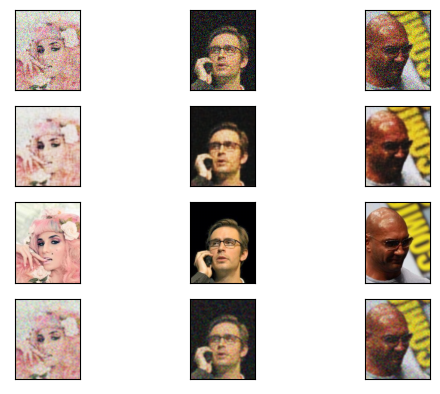

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True)
for images, row in zip([noise_test_set[:3], predicted, X_test, blured_test_set], axes):
    for img, ax in zip(images, row):
        #ax.imshow(img.reshape((216, 64)))
        ax.imshow(img.reshape((216, 176, 3)))        
        #ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

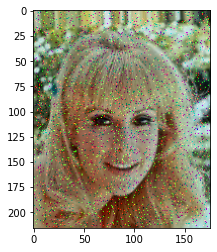

In [ ]:
plt.imshow(noise_test_set[1])

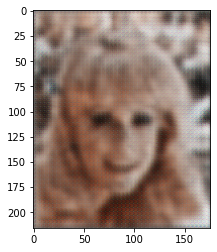

In [ ]:
plt.imshow(predicted[1])

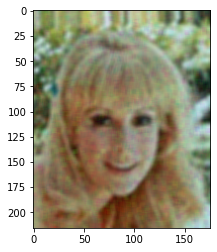

In [ ]:
plt.imshow(blured_test_set[1])

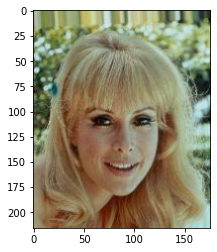

In [ ]:
plt.imshow(X_test[1])

As the result, it makes sense to use convolutional neural networks as encoders and decoders. However, the convolutional autoencoders generate a very blured version of the original image.

Compared to the Gaussian bluring, the results with convolutional networks are in my opinion better in case of heavy noice. 

In case of not buch noice on the images, it is most likely better to use Gaussian bluring.

Tested noise type: salt&pepper, poisson, speckle